# Análise de sentimentos em crítica de filmes

## Objetivo: saber se a crítica foi boa ou ruim

* fonte: https://www.kaggle.com/luisfredgs/imdb-ptbr

### Detalhes da fonte

 1. Originalmente foi feita em inglês e traduzida automaticamente para pt br, portanto podem ter erros na tradução
 2. Os dados já contém a resposta se a crítica foi boa ou não
 


In [7]:
import pandas as pd

df = pd.read_csv("C:/Users/samsung/Desktop/datasets/imdb/imdb-reviews-pt-br.csv")

In [8]:
df.head(3)

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg


In [9]:
df.shape # ok tem um tamanho bom de dados para analisar

(49459, 4)

In [10]:
df.sentiment.value_counts() # ok tbm, os resultados têm uma boa proporção

neg    24765
pos    24694
Name: sentiment, dtype: int64

### Criando uma Base Line

In [11]:
# primeiro vou colocar a coluna sentment no padrão de resposta esperado

df["sentiment"] = df["sentiment"].replace(['neg','pos'],[0,1])
df.head(2)

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
# ficaaria muito custoso computacionalmente usar tudo
# peguei apenas as 100 palavras mais usadas

vetorizador = CountVectorizer(lowercase = False, max_features = 100) 
bag_of_words = vetorizador.fit_transform(df.text_pt) 
bag_of_words.shape

(49459, 100)

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bag_of_words, df.sentiment, test_size=0.33, random_state=42)

In [24]:
from sklearn.linear_model import LogisticRegression
reg_log = LogisticRegression()

reg_log.fit(x_train,y_train)
reg_log.score(x_test,y_test)

C:\Users\samsung\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7035902462933464

 ### Impressões 
 
 * Uma acurácia de 70% não é de se jogar fora e, dependendo do tipo de problema ou da regra de negócio, poderíamos ficar por aqui mesmo. Obviamente, não vamos fazer isso por se tratar de um exercício
 
 * Agora preciso colocar as palavras mais relevantes nas 100 usadas pelo countVectorizer

In [26]:
# criei essa função pra poder usar várias vezes

def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=100)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                              texto[coluna_classificacao],
                                                              random_state = 42)
    regressao_logistica = LogisticRegression(solver = "lbfgs")
    regressao_logistica.fit(treino, classe_treino)
    return regressao_logistica.score(teste, classe_teste)

In [31]:
%matplotlib inline

from wordcloud import WordCloud
todas_as_palavras = ' '.join([texto for texto in df.text_pt]) # é a estrutura de dados que a wordcloud entende
len(todas_as_palavras)

63448424

In [38]:
nuvem_de_palavras = WordCloud(width = 800, height = 500,
                             max_font_size = 110,
                             collocations = False).generate(todas_as_palavras)

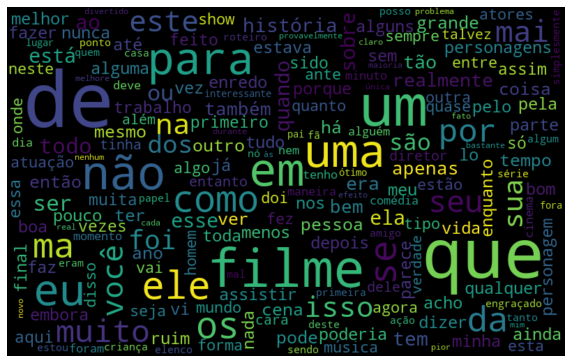

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.imshow(nuvem_de_palavras,interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Observações

1. Separando em 2 nuvens, uma para os sentimentos positivos e outra pros negativos, vai ser possível ter novas ideias
2. Tem muitas stopwords, removê-las pode melhorar o modelo

#### Separando a nuvem de acordo com o sentimento

In [59]:
def gerador_nuvem(coluna,sentiment):
    query = 'sentiment == ' + str(sentiment)
    df_n = df.query(query)
    palavras_n = ' '.join([texto for texto in df_n[coluna]]) 
    nuvem_n = WordCloud(width = 800, height = 500,
                             max_font_size = 110,
                             collocations = False).generate(palavras_n)

    plt.figure(figsize = (10,7))
    plt.imshow(nuvem_boa,interpolation = 'bilinear')
    plt.axis("off")
    plt.show()

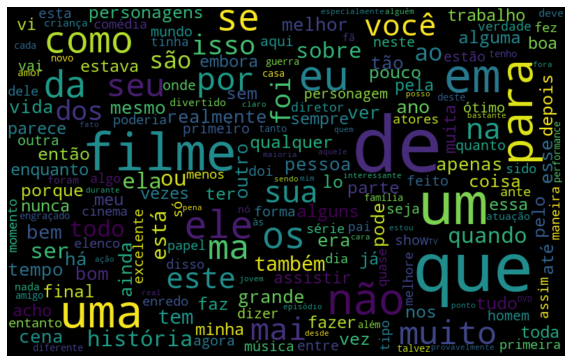

In [60]:
# sentimentos bons
gerador_nuvem('text_pt', 1)

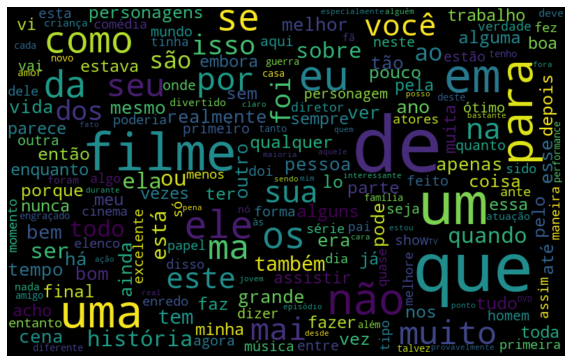

In [61]:
# Sentimentos ruins 
gerador_nuvem('text_pt', 0)

### Observações

1. Criar as nuvens de palavras por sentimento não foi de grande valia
2. Remover as stop words ainda é uma alternativa viável

#### Removendo as stop words:

In [47]:
import nltk
from nltk import tokenize

tokenizador = tokenize.WhitespaceTokenizer()

In [53]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("portuguese")

texto_processado = []
for critica in df.text_pt:
    palavras_relevantes = []
    critica_tokenizada = tokenizador.tokenize(critica)
    for palavra in critica_tokenizada:
        if palavra not in stop_words:
            palavras_relevantes.append(palavra)
    texto_processado.append(' '.join(palavras_relevantes))

df['text_stopwords'] = texto_processado
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samsung\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,id,text_en,text_pt,sentiment,text_stopwords
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,0,"Filmes fotos latão palavra apropriada eles, ve..."


In [55]:
classificar_texto(df,'text_stopwords', 'sentiment')

0.7096643752527295

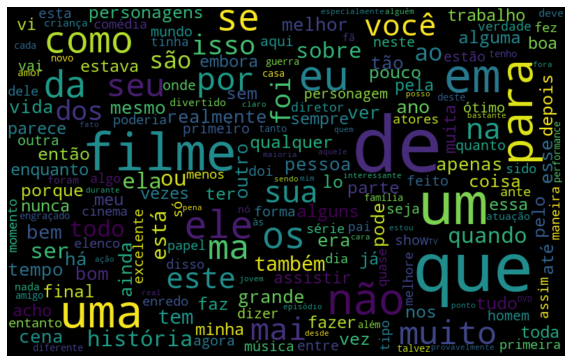

In [62]:
gerador_nuvem('text_stopwords',1)

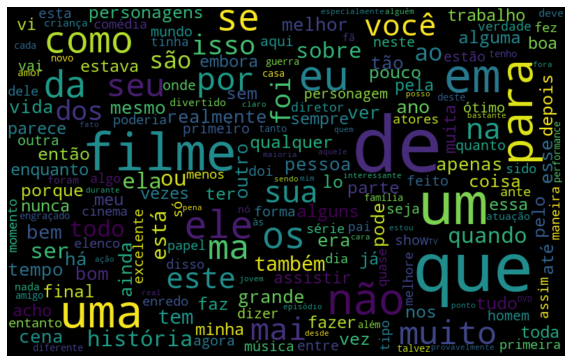

In [63]:
gerador_nuvem('text_stopwords',0)

### Observações 

1. Esse tratamento inicial melhorou o modelo, mas não de forma significativa
2. Ainda temos muitas stop words para remover